# Download Data

In [1]:
!wget -q https://hkustconnect-my.sharepoint.com/:u:/g/personal/nnanda_connect_ust_hk/EfREjZqiZTlPqhqUPICBbPABdlgPumlaUVxPncm-_9aWIw?download=1 -O "Project 1 - data.zip"
!unzip -q "Project 1 - data.zip"


# Import Libraries

In [2]:
!pip -q install keras-layer-normalization

In [3]:
import os
import nltk
import math
import scipy
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Activation, Input, Add, Concatenate, Embedding, Conv1D, MaxPool1D, Flatten, LSTM, Bidirectional
from keras_layer_normalization import LayerNormalization
from keras.utils import Sequence
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [4]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

# Data Loader

In [6]:
def load_data(split_name='train', columns=['text', 'stars']):
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        df = df.loc[:,columns]
        print("succeed!")
        return df
    except:
        print("Failed, then try to ")
        print(f"select all columns from the {split_name} split")
        df = pd.read_csv(f'data_2021_spring/{split_name}.csv')
        return df

In [7]:
train_df = load_data('train', columns=['full'])
valid_df = load_data('valid', columns=['full'])
test_df = load_data('test', columns=['full'])

select [full] columns from the train split
Failed, then try to 
select all columns from the train split
select [full] columns from the valid split
Failed, then try to 
select all columns from the valid split
select [full] columns from the test split
Failed, then try to 
select all columns from the test split


In [8]:
train_df.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
0,39rLHYJOy2774ZIUouuWLw,0,2017-06-28 21:44:02,0,ynzOFepQYSCDGdfWDWxiZw,4,Nice to have a diner still around. Food was go...,0,Sl6VgFOB-XXfFIAYp7TFkw
1,E-Kq1Yu1d6N3TL2qX0aqjA,0,2018-04-09 03:45:19,0,sQX9ncJBEdBf16AWsvO6Vg,2,"Tried this a while back, got the fried chicken...",0,gcx01pMqWzkni2UC-zoZrA
2,nWW6fBfBljiRFa4sG7TyxA,0,2014-07-19 02:00:04,0,bVIf2kqbzvif3miNe3ARNw,4,I expected more pork selections on menu. Food ...,0,Mn9VzPbrCYU4EcP_C1oBOg
3,qmIHO-6T_KEfPC9jyGDamQ,0,2011-11-11 08:10:24,0,LNj1OFxy2ool3PZANGchPA,4,YUMMY!!! This place is phenomenal. It is Price...,0,SKV1heo00fdciCbCN9Z33A
4,pKk7jCFIm96qDdk0laVT2w,1,2010-01-16 20:04:00,1,bZXxa0hO6wQlHD-MkMf4iw,5,The Truffle Macaroni & Cheese and Potatoes Au ...,1,p1r7rZYruZR92x1A649PTQ


In [9]:
valid_df.describe()

,cool,funny,stars,useful
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.491000,0.544500,2.991500,1.404500
std,2.214581,2.484775,1.501851,3.356861
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,3.000000,0.000000
75%,0.000000,0.000000,4.000000,2.000000
max,79.000000,69.000000,5.000000,89.000000


# Feature Extractor

In [10]:
def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)

def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results
    
def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

In [11]:
def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param data: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out, type: int
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out, type: int
    :param max_size: the max size of feature dict, type: int
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = [f for f, cnt in feat_cnt.most_common(max_size)]
    else:
        valid_feats = list()
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and \
                (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]        
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_onehot_vector(feats, feats_dict):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

Bigram/Trigram better than Unigram in terms of Valid Accuracy

In [12]:
# load data
train_texts, train_labels = train_df["text"], train_df["stars"]
valid_texts, valid_labels = valid_df["text"], valid_df["stars"]

# extract features
train_tokens = [tokenize(text) for text in train_texts]
valid_tokens = [tokenize(text) for text in valid_texts]

train_stemmed = [stem(tokens) for tokens in train_tokens]
valid_stemmed = [stem(tokens) for tokens in valid_tokens]

train_stemmed = [filter_stopwords(tokens) for tokens in train_stemmed]
valid_stemmed = [filter_stopwords(tokens) for tokens in valid_stemmed]

train_2_gram = [n_gram(tokens, 2) for tokens in train_stemmed]
# train_3_gram = [n_gram(tokens, 3) for tokens in train_stemmed]
valid_2_gram = [n_gram(tokens, 2) for tokens in valid_stemmed]
# valid_3_gram = [n_gram(tokens, 3) for tokens in valid_stemmed]

# build the feature list
train_feats = list()
for i in range(len(train_labels)):
    # train_feats.append(train_stemmed[i] + train_2_gram[i] + train_3_gram[i])
    # train_feats.append(train_stemmed[i])
    train_feats.append(train_stemmed[i] + train_2_gram[i])
valid_feats = list()
for i in range(len(valid_labels)):
    # valid_feats.append(valid_stemmed[i] + valid_2_gram[i] + valid_3_gram[i])
    # valid_feats.append(valid_stemmed[i])
    valid_feats.append(valid_stemmed[i] + valid_2_gram[i])

# build a mapping from features to indices
feats_dict = get_feats_dict(
    chain.from_iterable(train_feats),
    min_freq=5)

# build the feats_matrix
# convert each example to a ont-hot vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in train_feats])
valid_feats_matrix = np.vstack(
    [get_onehot_vector(f, feats_dict) for f in valid_feats])

# convert labels to label_matrix
num_classes = max(train_labels)
# convert each label to a ont-hot vector, and then stack vectors as a matrix
train_label_matrix = keras.utils.to_categorical(train_labels-1, num_classes=num_classes)
valid_label_matrix = keras.utils.to_categorical(valid_labels-1, num_classes=num_classes)

Size of features: 29979


In [13]:
del train_tokens, train_stemmed, train_2_gram
del valid_tokens, valid_stemmed, valid_2_gram

In [14]:
print(train_feats_matrix.shape, valid_feats_matrix.shape)
print(train_label_matrix.shape, valid_label_matrix.shape)

(10000, 29979) (2000, 29979)
(10000, 5) (2000, 5)


# Text Generator - To avoid shortage of RAM 

In [15]:
BATCH_SIZE = 100

class TextSequence(Sequence):
    def __init__(self, usage, x, y, shuf):
        self.usage = usage
        self.x = x
        self.y = y
        self.shuf = shuf

    def __len__(self):
        return len(self.x) // BATCH_SIZE

    def __getitem__(self, idx):
        index_sent = idx * BATCH_SIZE
        length = min(BATCH_SIZE, (len(self.x) - index_sent))
        batch_y = self.y[index_sent:index_sent+length]
        batch_x = self.x[index_sent:index_sent+length]

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuf == True:
            self.x, self.y = shuffle(self.x, self.y)

In [16]:
train_sequence = TextSequence("Train", train_feats_matrix[:9000], train_label_matrix[:9000], True)
valid_sequence = TextSequence("Valid", train_feats_matrix[9000:], train_label_matrix[9000:], True)

# shuffle_x, shuffle_y = shuffle(train_feats_matrix, train_label_matrix, random_state=0)
# train_sequence = TextSequence("Train", shuffle_x[:9000], shuffle_y[:9000], True)
# valid_sequence = TextSequence("Valid", shuffle_x[9000:], shuffle_y[9000:], True)

In [17]:
x, y = train_sequence.__getitem__(0)
x.shape, y.shape

((100, 29979), (100, 5))

In [18]:
xv, yv = valid_sequence.__getitem__(0)
xv.shape, yv.shape

((100, 29979), (100, 5))

# Training Parameters

In [19]:
EPOCHS = 100
# BATCH_SIZE = 100 defined before Data Generator
TRAIN_SPLIT = 9000
VALID_SPLIT = 1000


# SLP

In [ ]:
def build_classifier(input_size, output_size,
                     l2_reg=0.0,
                     loss="categorical_crossentropy",
                     optimizer="SGD",
                     learning_rate=0.1,
                     metric="accuracy"):
    """
    :param input_size: the dimension of the input, type: int
    :param output_size: the dimension of the prediction, type: int
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a 1-layer perceptron,
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    model = Sequential()
    
    # the projection layer
    model.add(Dense(output_size,
                    activation="softmax",
                    input_dim=input_size,
                    kernel_initializer=keras.initializers.he_normal(seed=0),
                    bias_initializer="zeros",
                    kernel_regularizer=keras.regularizers.l2(l2_reg)))
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [ ]:
os.makedirs("models", exist_ok=True)
model = build_classifier(input_size=len(feats_dict), output_size=num_classes,
                         l2_reg=0.005, learning_rate=0.1)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights_slp.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
slp_history = model.fit_generator(generator=train_sequence,
                    epochs=EPOCHS, steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE, 
                    callbacks=[checkpointer, reduce_lr, earlystopping], 
                    validation_data=valid_sequence, 
                    validation_steps=VALID_SPLIT//BATCH_SIZE, 
                    verbose=1, shuffle=True)

model = keras.models.load_model(os.path.join("models", "weights_slp.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
90/90 [==============================] - 4s 13ms/step - loss: 1.5234 - accuracy: 0.4062 - val_loss: 1.3223 - val_accuracy: 0.5220
Epoch 2/100
90/90 [==============================] - 1s 9ms/step - loss: 1.2623 - accuracy: 0.5684 - val_loss: 1.2442 - val_accuracy: 0.5560
Epoch 3/100
90/90 [==============================] - 1s 9ms/step - loss: 1.1595 - accuracy: 0.6190 - val_loss: 1.2164 - val_accuracy: 0.5650
Epoch 4/100
90/90 [==============================] - 1s 9ms/step - loss: 1.1016 - accuracy: 0.6524 - val_loss: 1.2052 - val_accuracy: 0.5670
Epoch 5/100
90/90 [==============================] - 1s 9ms/step - loss: 1.0716 - accuracy: 0.6705 - val_loss: 1.2021 - val_accuracy: 0.5810
Epoch 6/100
90/90 [==============================] - 1s 10ms/step - loss: 1.0531 - accuracy: 0.6879 - val_loss: 1.2015 - val_accuracy: 0.5810
Epoch 7/100
90/90 [==============================] - 1s 9ms/step - loss: 1.0270 - accuracy: 0.7082 - val_loss: 1.2008 - val_accuracy: 0.5820
Epoch 8/100

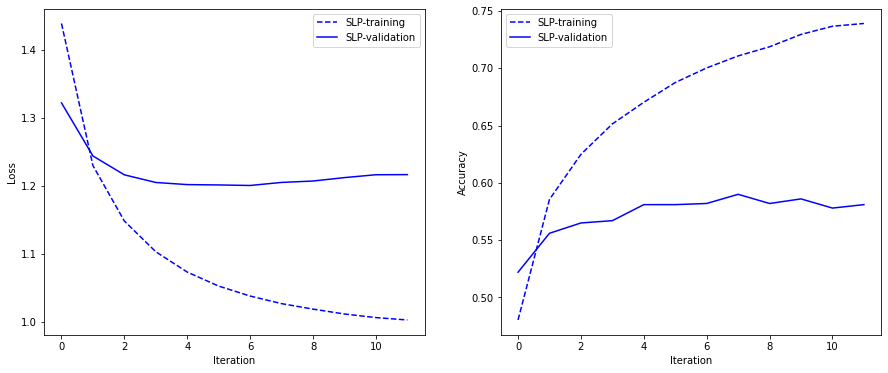

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(slp_history.history["loss"], label="SLP-training", color="blue", linestyle="dashed")
plt.plot(slp_history.history["val_loss"], label="SLP-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(slp_history.history["accuracy"], label="SLP-training", color="blue", linestyle="dashed")
plt.plot(slp_history.history["val_accuracy"], label="SLP-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# MLP

In [20]:
def build_MLP(input_size, output_size, num_layers, hidden_size,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              layer_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric="accuracy"):
    """
    :param input_size: the dimension of the input, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_layers: the number of layers, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param layer_norm: whether to enable layer normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a multi-layer perceptron,
    # activation
    # dropout document: https://keras.io/layers/core/#dropout
    # batch normalization document: https://keras.io/layers/normalization/
    # layer normalization: https://github.com/CyberZHG/keras-layer-normalization
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    model = Sequential()
    
    if num_layers == 1:
        model.add(Dense(output_size,
                        activation="softmax",
                        input_dim=input_size,
                        kernel_initializer=keras.initializers.he_normal(seed=0),   #normal distribution initializer
                        bias_initializer="zeros",
                        kernel_regularizer=keras.regularizers.l2(l2_reg)))
    else:
        for i in range(num_layers-1):
            if i == 0:
                # fitst layer: input -> hidden
                model.add(Dense(hidden_size,
                                input_dim=input_size,
                                kernel_initializer=keras.initializers.he_normal(seed=0),
                                bias_initializer="zeros",
                                kernel_regularizer=keras.regularizers.l2(l2_reg)))
            else:
                # hidden layers: hidden -> hidden
                model.add(Dense(hidden_size,
                                input_dim=hidden_size,
                                kernel_initializer=keras.initializers.he_normal(seed=0),
                                bias_initializer="zeros",
                                kernel_regularizer=keras.regularizers.l2(l2_reg)))
            # add layer_norm
            if layer_norm:
                model.add(LayerNormalization())
            # add batch_norm
            if batch_norm:
                model.add(BatchNormalization())
            # add activation
            model.add(Activation(activation))
            # add dropout here (set seed as 0 in order to reproduce)
            if dropout_rate > 0.0:
                model.add(Dropout(dropout_rate, seed=0))
        # last layer: hidden -> class
        model.add(Dense(output_size,
                        activation="softmax",
                        input_dim=hidden_size,
                        kernel_initializer=keras.initializers.he_normal(seed=0),
                        bias_initializer="zeros"))
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [ ]:
model = build_MLP(input_size=len(feats_dict), output_size=num_classes,
                  num_layers=2, hidden_size=200, activation="relu",
                  l2_reg=0.005, learning_rate=0.1)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights_mlp.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=0)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
mlp_history = model.fit_generator(generator=train_sequence,
                    epochs=EPOCHS, steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE, 
                    callbacks=[checkpointer, reduce_lr, earlystopping], 
                    validation_data=valid_sequence, 
                    validation_steps=VALID_SPLIT//BATCH_SIZE, 
                    verbose=1, shuffle=True)

model = keras.models.load_model(os.path.join("models", "weights_mlp.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
90/90 [==============================] - 1s 12ms/step - loss: 3.3794 - accuracy: 0.3985 - val_loss: 2.8470 - val_accuracy: 0.5420
Epoch 2/100
90/90 [==============================] - 1s 12ms/step - loss: 2.6546 - accuracy: 0.6145 - val_loss: 2.4754 - val_accuracy: 0.5740
Epoch 3/100
90/90 [==============================] - 1s 10ms/step - loss: 2.2423 - accuracy: 0.6862 - val_loss: 2.2342 - val_accuracy: 0.5810
Epoch 4/100
90/90 [==============================] - 1s 10ms/step - loss: 1.9183 - accuracy: 0.7391 - val_loss: 2.0566 - val_accuracy: 0.5830
Epoch 5/100
90/90 [==============================] - 1s 10ms/step - loss: 1.6585 - accuracy: 0.7899 - val_loss: 1.9032 - val_accuracy: 0.5890
Epoch 6/100
90/90 [==============================] - 1s 10ms/step - loss: 1.4569 - accuracy: 0.8225 - val_loss: 1.8244 - val_accuracy: 0.5690
Epoch 7/100
90/90 [==============================] - 1s 10ms/step - loss: 1.2777 - accuracy: 0.8544 - val_loss: 1.7118 - val_accuracy: 0.5790
Epoch 

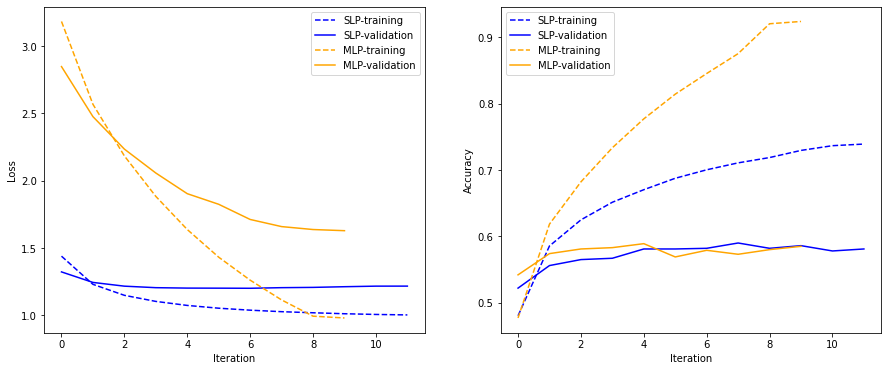

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(slp_history.history["loss"], label="SLP-training", color="blue", linestyle="dashed")
plt.plot(slp_history.history["val_loss"], label="SLP-validation", color="blue")
plt.plot(mlp_history.history["loss"], label="MLP-training", color="orange", linestyle="dashed")
plt.plot(mlp_history.history["val_loss"], label="MLP-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(slp_history.history["accuracy"], label="SLP-training", color="blue", linestyle="dashed")
plt.plot(slp_history.history["val_accuracy"], label="SLP-validation", color="blue")
plt.plot(mlp_history.history["accuracy"], label="MLP-training", color="orange", linestyle="dashed")
plt.plot(mlp_history.history["val_accuracy"], label="MLP-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Adding dropout to avoid overfitting

In [ ]:
model = build_MLP(input_size=len(feats_dict), output_size=num_classes,
                  num_layers=3, hidden_size=200, activation="relu",
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights_mlp_drop.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=1)

np.random.seed(0)
tf.random.set_seed(0)
drop_history = model.fit_generator(generator=train_sequence,
                    epochs=EPOCHS, steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE, 
                    callbacks=[checkpointer, reduce_lr, earlystopping], 
                    validation_data=valid_sequence, 
                    validation_steps=VALID_SPLIT//BATCH_SIZE, 
                    verbose=1, shuffle=True)

model = keras.models.load_model(os.path.join("models", "weights_mlp_drop.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
90/90 [==============================] - 1s 12ms/step - loss: 5.3456 - accuracy: 0.3530 - val_loss: 4.5172 - val_accuracy: 0.5400
Epoch 2/100
90/90 [==============================] - 1s 10ms/step - loss: 4.3828 - accuracy: 0.5242 - val_loss: 3.8795 - val_accuracy: 0.5720
Epoch 3/100
90/90 [==============================] - 1s 10ms/step - loss: 3.6952 - accuracy: 0.6220 - val_loss: 3.4165 - val_accuracy: 0.5760
Epoch 4/100
90/90 [==============================] - 1s 10ms/step - loss: 3.1694 - accuracy: 0.6712 - val_loss: 3.0414 - val_accuracy: 0.5800
Epoch 5/100
90/90 [==============================] - 1s 10ms/step - loss: 2.7305 - accuracy: 0.7130 - val_loss: 2.7535 - val_accuracy: 0.5860
Epoch 6/100
90/90 [==============================] - 1s 10ms/step - loss: 2.3714 - accuracy: 0.7445 - val_loss: 2.5386 - val_accuracy: 0.5640
Epoch 7/100
90/90 [==============================] - 1s 10ms/step - loss: 2.0727 - accuracy: 0.7782 - val_loss: 2.3467 - val_accuracy: 0.5850
Epoch 

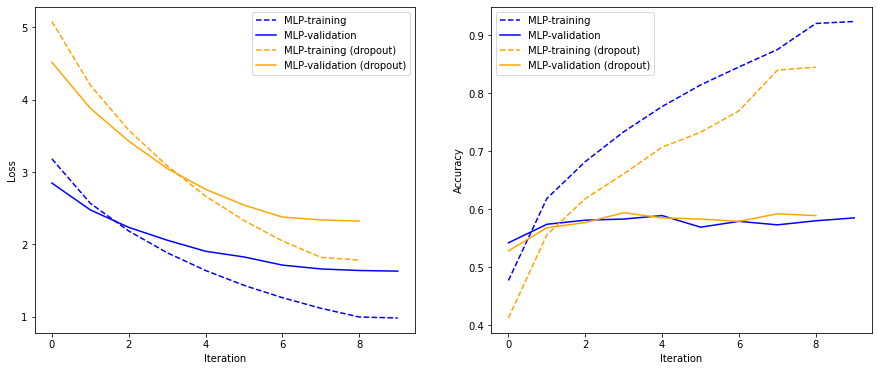

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(mlp_history.history["loss"], label="MLP-training", color="blue", linestyle="dashed")
plt.plot(mlp_history.history["val_loss"], label="MLP-validation", color="blue")
plt.plot(drop_history.history["loss"], label="MLP-training (dropout)", color="orange", linestyle="dashed")
plt.plot(drop_history.history["val_loss"], label="MLP-validation (dropout)", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(mlp_history.history["accuracy"], label="MLP-training", color="blue", linestyle="dashed")
plt.plot(mlp_history.history["val_accuracy"], label="MLP-validation", color="blue")
plt.plot(drop_history.history["accuracy"], label="MLP-training (dropout)", color="orange", linestyle="dashed")
plt.plot(drop_history.history["val_accuracy"], label="MLP-validation (dropout)", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Layer Normalisation vs Batch Normalisation

In [ ]:
histories = list()
for batch_norm in [False, True]:
    for layer_norm in [False, True]:
        model = build_MLP(input_size=len(feats_dict), output_size=num_classes,
                          num_layers=3, hidden_size=200, activation="relu",
                          batch_norm=batch_norm, layer_norm=layer_norm)
        checkpointer = keras.callbacks.ModelCheckpoint(
            filepath=os.path.join("models", "weights.hdf5"),
            monitor="val_accuracy",
            verbose=0,
            save_best_only=True)
        
        earlystopping = keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            verbose=0)

        np.random.seed(0)
        tf.random.set_seed(0)

        history = model.fit_generator(generator=train_sequence,
                    epochs=EPOCHS, steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE, 
                    callbacks=[checkpointer, reduce_lr, earlystopping], 
                    validation_data=valid_sequence, 
                    validation_steps=VALID_SPLIT//BATCH_SIZE, 
                    verbose=1, shuffle=True)

        # history = model.fit(train_feats_matrix, train_label_matrix,
        #                     validation_split=0.1,
        #                     epochs=20, batch_size=100, verbose=0,
        #                     callbacks=[checkpointer, earlystopping])
        model = keras.models.load_model(os.path.join("models", "weights.hdf5"),
                                        custom_objects={"LayerNormalization": LayerNormalization})

        train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                     batch_size=100)
        valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
        
        histories.append((batch_norm, layer_norm, history))
        print("batch normalization:", batch_norm, "layer normalization:", layer_norm)        
        print("training loss:", train_score[0], "training accuracy", train_score[1])
        print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
90/90 [==============================] - 1s 11ms/step - loss: 1.4362 - accuracy: 0.4062 - val_loss: 1.0562 - val_accuracy: 0.5480
Epoch 2/100
90/90 [==============================] - 1s 11ms/step - loss: 0.9258 - accuracy: 0.6404 - val_loss: 1.0296 - val_accuracy: 0.5520
Epoch 3/100
90/90 [==============================] - 1s 11ms/step - loss: 0.7159 - accuracy: 0.7285 - val_loss: 1.3488 - val_accuracy: 0.5000
Epoch 4/100
90/90 [==============================] - 1s 10ms/step - loss: 0.5445 - accuracy: 0.8051 - val_loss: 1.1525 - val_accuracy: 0.5550
Epoch 5/100
90/90 [==============================] - 1s 10ms/step - loss: 0.3744 - accuracy: 0.8909 - val_loss: 1.1688 - val_accuracy: 0.5580
Epoch 6/100
90/90 [==============================] - 1s 10ms/step - loss: 0.2719 - accuracy: 0.9293 - val_loss: 1.3054 - val_accuracy: 0.5660
Epoch 7/100
90/90 [==============================] - 1s 10ms/step - loss: 0.1692 - accuracy: 0.9670 - val_loss: 1.3682 - val_accuracy: 0.5650
Epoch 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reus

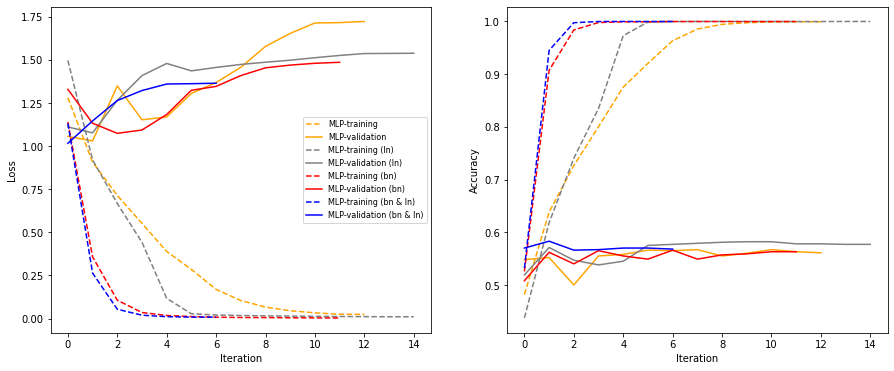

In [ ]:
colors = ["orange", "gray", "red", "blue"]
plt.figure(figsize=(15,6))

for i, (batch_norm, layer_norm, history) in enumerate(histories):
    if batch_norm and layer_norm:
        name = " (bn & ln)"
    elif batch_norm and not layer_norm:
        name = " (bn)"
    elif not batch_norm and layer_norm:
        name = " (ln)"
    else:
        name = ""
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_loss"], label="MLP-validation" + name, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="MLP-validation" + name, color=colors[i])
plt.subplot(1,2,1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.subplot(1,2,2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

# Residual Connection

In [ ]:
def build_Res_Net(input_size, output_size, num_layers, hidden_size,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              layer_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric="accuracy"):
    """
    :param input_size: the dimension of the input, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_layers: the number of layers, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param layer_norm: whether to enable layer normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a multi-layer network with residual connections,
    # activation
    # dropout document: https://keras.io/layers/core/#dropout
    # batch normalization document: https://keras.io/layers/normalization/
    # layer normalization: https://github.com/CyberZHG/keras-layer-normalization
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_size,))
    
    if num_layers == 1:
        y = Dense(output_size,
                  activation="softmax",
                  input_dim=input_size,
                  kernel_initializer=keras.initializers.he_normal(seed=0),
                  bias_initializer="zeros",
                  kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    else:
        h = x
        for i in range(num_layers-1):
            if i == 0:
                # fitst layer: input -> hidden
                new_h = Dense(hidden_size,
                          input_dim=input_size,
                          kernel_initializer=keras.initializers.he_normal(seed=0),
                          bias_initializer="zeros",
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
            else:
                new_h = Dense(hidden_size,
                          input_dim=hidden_size,
                          kernel_initializer=keras.initializers.he_normal(seed=0),
                          bias_initializer="zeros",
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
            # add layer_norm
            if layer_norm:
                new_h = LayerNormalization()(new_h)
            # add batch_norm
            if batch_norm:
                new_h = BatchNormalization()(new_h)
            # residual connection
            if i == 0:
                h = new_h
            else:
                h = Add()([h, new_h])
            # add activation
            h = Activation(activation)(h)
            # add dropout here (set seed as 0 in order to reproduce)
            if dropout_rate > 0.0:
                h = Dropout(dropout_rate, seed=0)(h)
        # last layer: hidden -> class
        y = Dense(output_size,
                  activation="softmax",
                  input_dim=hidden_size,
                  kernel_initializer=keras.initializers.he_normal(seed=0),
                  bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [ ]:
model = build_Res_Net(input_size=len(feats_dict), output_size=num_classes,
                  num_layers=3, hidden_size=200, activation="relu",
                  l2_reg=0.005, dropout_rate=0.1)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights_res.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
res_history = model.fit_generator(generator=train_sequence,
                    epochs=EPOCHS, steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE, 
                    callbacks=[checkpointer, reduce_lr, earlystopping], 
                    validation_data=valid_sequence, 
                    validation_steps=VALID_SPLIT//BATCH_SIZE, 
                    verbose=1, shuffle=True)
model = keras.models.load_model(os.path.join("models", "weights_res.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
90/90 [==============================] - 1s 12ms/step - loss: 5.2215 - accuracy: 0.4282 - val_loss: 4.4178 - val_accuracy: 0.5480
Epoch 2/100
90/90 [==============================] - 1s 11ms/step - loss: 4.1221 - accuracy: 0.6508 - val_loss: 3.9591 - val_accuracy: 0.5360
Epoch 3/100
90/90 [==============================] - 1s 10ms/step - loss: 3.4637 - accuracy: 0.7269 - val_loss: 3.4248 - val_accuracy: 0.5650
Epoch 4/100
90/90 [==============================] - 1s 10ms/step - loss: 2.8813 - accuracy: 0.8096 - val_loss: 3.1231 - val_accuracy: 0.5700
Epoch 5/100
90/90 [==============================] - 1s 10ms/step - loss: 2.4251 - accuracy: 0.8701 - val_loss: 2.9192 - val_accuracy: 0.5580
Epoch 6/100
90/90 [==============================] - 1s 10ms/step - loss: 2.0788 - accuracy: 0.8885 - val_loss: 2.8554 - val_accuracy: 0.5330
Epoch 7/100
90/90 [==============================] - 1s 10ms/step - loss: 1.7888 - accuracy: 0.9150 - val_loss: 2.6057 - val_accuracy: 0.5460
Epoch 

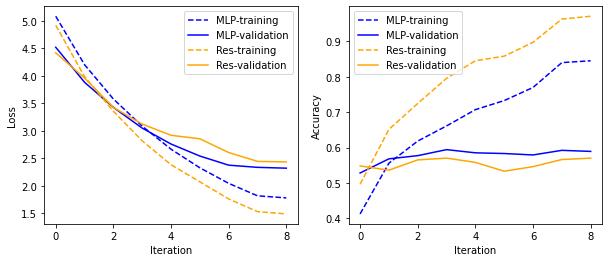

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(drop_history.history["loss"], label="MLP-training", color="blue", linestyle="dashed")
plt.plot(drop_history.history["val_loss"], label="MLP-validation", color="blue")
plt.plot(res_history.history["loss"], label="Res-training", color="orange", linestyle="dashed")
plt.plot(res_history.history["val_loss"], label="Res-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(drop_history.history["accuracy"], label="MLP-training", color="blue", linestyle="dashed")
plt.plot(drop_history.history["val_accuracy"], label="MLP-validation", color="blue")
plt.plot(res_history.history["accuracy"], label="Res-training", color="orange", linestyle="dashed")
plt.plot(res_history.history["val_accuracy"], label="Res-validation", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Concatenation

In [ ]:
def build_Cat_Net(input_size, output_size, num_layers, hidden_size,
              activation="relu",
              dropout_rate=0.0,
              batch_norm=False,
              layer_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="SGD",
              learning_rate=0.1,
              metric="accuracy"):
    """
    :param input_size: the dimension of the input, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_layers: the number of layers, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param layer_norm: whether to enable layer normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a multi-layer networks with concatenations,
    # activation
    # dropout document: https://keras.io/layers/core/#dropout
    # batch normalization document: https://keras.io/layers/normalization/
    # layer normalization: https://github.com/CyberZHG/keras-layer-normalization
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_size,))
    
    if num_layers == 1:
        y = Dense(output_size,
                  activation="softmax",
                  input_dim=input_size,
                  kernel_initializer=keras.initializers.he_normal(seed=0),
                  bias_initializer="zeros",
                  kernel_regularizer=keras.regularizers.l2(l2_reg))(x)
    else:
        h = x
        for i in range(num_layers-1):
            if i == 0:
                # fitst layer: input -> hidden
                new_h = Dense(hidden_size,
                          input_dim=input_size,
                          kernel_initializer=keras.initializers.he_normal(seed=0),
                          bias_initializer="zeros",
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
            else:
                new_h = Dense(hidden_size,
                          kernel_initializer=keras.initializers.he_normal(seed=0),
                          bias_initializer="zeros",
                          kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
            # add layer_norm
            if layer_norm:
                new_h = LayerNormalization()(new_h)
            # add batch_norm
            if batch_norm:
                new_h = BatchNormalization()(new_h)
            # residual connection
            if i == 0:
                h = new_h
            else:
                h = Concatenate()([h, new_h])
            # add activation
            h = Activation(activation)(h)
            # add dropout here (set seed as 0 in order to reproduce)
            if dropout_rate > 0.0:
                h = Dropout(dropout_rate, seed=0)(h)
        # last layer: hidden -> class
        y = Dense(output_size,
                  activation="softmax",
                  kernel_initializer=keras.initializers.he_normal(seed=0),
                  bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

In [ ]:
model = build_Cat_Net(input_size=len(feats_dict), output_size=num_classes,
                  num_layers=3, hidden_size=200, activation="relu",
                  l2_reg=0.005, dropout_rate=0.0)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights_cat.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)
cat_history = model.fit_generator(generator=train_sequence,
                    epochs=EPOCHS, steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE, 
                    callbacks=[checkpointer, reduce_lr, earlystopping], 
                    validation_data=valid_sequence, 
                    validation_steps=VALID_SPLIT//BATCH_SIZE, 
                    verbose=1, shuffle=True)
model = keras.models.load_model(os.path.join("models", "weights_cat.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
90/90 [==============================] - 1s 12ms/step - loss: 5.2805 - accuracy: 0.4112 - val_loss: 4.4932 - val_accuracy: 0.5200
Epoch 2/100
90/90 [==============================] - 1s 10ms/step - loss: 4.1895 - accuracy: 0.6312 - val_loss: 3.9548 - val_accuracy: 0.5450
Epoch 3/100
90/90 [==============================] - 1s 10ms/step - loss: 3.4846 - accuracy: 0.7189 - val_loss: 3.4150 - val_accuracy: 0.5820
Epoch 4/100
90/90 [==============================] - 1s 11ms/step - loss: 2.9618 - accuracy: 0.7656 - val_loss: 3.0664 - val_accuracy: 0.5830
Epoch 5/100
90/90 [==============================] - 1s 11ms/step - loss: 2.4801 - accuracy: 0.8388 - val_loss: 2.8388 - val_accuracy: 0.5820
Epoch 6/100
90/90 [==============================] - 1s 10ms/step - loss: 2.1521 - accuracy: 0.8538 - val_loss: 2.6073 - val_accuracy: 0.5770
Epoch 7/100
90/90 [==============================] - 1s 10ms/step - loss: 1.8147 - accuracy: 0.9036 - val_loss: 2.4757 - val_accuracy: 0.5620
Epoch 

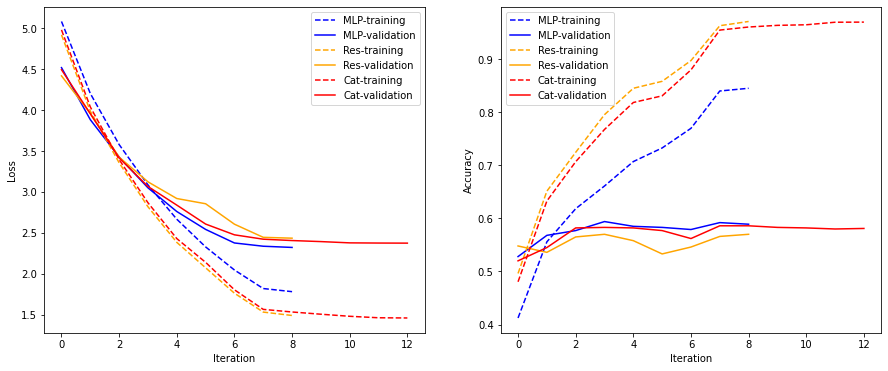

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(drop_history.history["loss"], label="MLP-training", color="blue", linestyle="dashed")
plt.plot(drop_history.history["val_loss"], label="MLP-validation", color="blue")
plt.plot(res_history.history["loss"], label="Res-training", color="orange", linestyle="dashed")
plt.plot(res_history.history["val_loss"], label="Res-validation", color="orange")
plt.plot(cat_history.history["loss"], label="Cat-training", color="red", linestyle="dashed")
plt.plot(cat_history.history["val_loss"], label="Cat-validation", color="red")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(drop_history.history["accuracy"], label="MLP-training", color="blue", linestyle="dashed")
plt.plot(drop_history.history["val_accuracy"], label="MLP-validation", color="blue")
plt.plot(res_history.history["accuracy"], label="Res-training", color="orange", linestyle="dashed")
plt.plot(res_history.history["val_accuracy"], label="Res-validation", color="orange")
plt.plot(cat_history.history["accuracy"], label="Cat-training", color="red", linestyle="dashed")
plt.plot(cat_history.history["val_accuracy"], label="Cat-validation", color="red")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Testing hyperparameters on MLP

In [21]:
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights_mlp.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=3, verbose=0)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    verbose=0)

## Testing Optimizers

Default:
* num_layers = 2
* hidden_size = 200
* activation = "relu"
* learning_rate = 0.1
* optimizer = "SGD"

In [22]:
optimizers = ["SGD", "RMSprop", "Adam"]
opt_histories = []

for o in optimizers:
    model = build_MLP(input_size=len(feats_dict), output_size=num_classes,
                    num_layers=2, hidden_size=200, activation="relu",
                    learning_rate=0.1, optimizer=o)
    
    checkpointer = keras.callbacks.ModelCheckpoint(
      filepath=os.path.join("models", "weights_mlp_" + o + ".hdf5"),
      monitor="val_accuracy",
      verbose=0,
      save_best_only=True)
    
    history = model.fit_generator(generator=train_sequence,
                      epochs=EPOCHS, steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE, 
                      callbacks=[checkpointer, earlystopping], 
                      validation_data=valid_sequence, 
                      validation_steps=VALID_SPLIT//BATCH_SIZE, 
                      verbose=0, shuffle=True)
    
    model = keras.models.load_model(os.path.join("models", "weights_mlp_" + o + ".hdf5"))
    opt_histories.append((o, history))

    print("Optimizer:", o)

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                batch_size=100)
    valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Optimizer: SGD
20/20 [==============================] - 0s 7ms/step - loss: 0.9909 - accuracy: 0.6060
training loss: 0.6555886268615723 training accuracy 0.7849000096321106
valid loss: 0.9909349679946899 valid accuracy 0.6060000061988831
Optimizer: RMSprop
20/20 [==============================] - 0s 7ms/step - loss: 1.0667 - accuracy: 0.5915
training loss: 0.27166953682899475 training accuracy 0.9284999966621399
valid loss: 1.066727876663208 valid accuracy 0.5914999842643738
Optimizer: Adam
20/20 [==============================] - 0s 6ms/step - loss: 0.9594 - accuracy: 0.6055
training loss: 0.4865952134132385 training accuracy 0.8744000196456909
valid loss: 0.9593960046768188 valid accuracy 0.6054999828338623


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

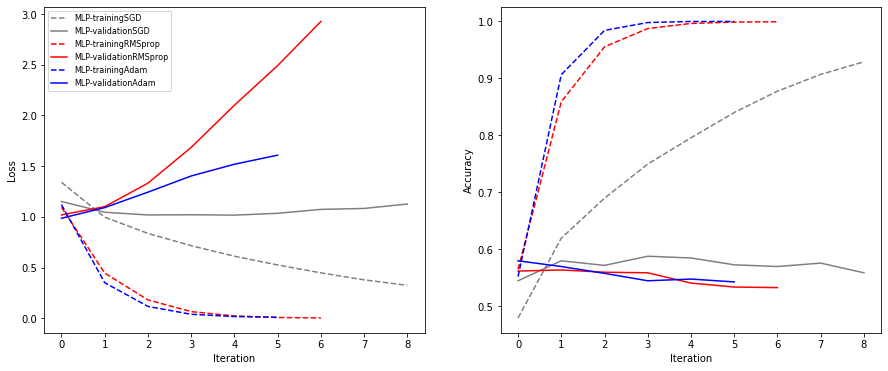

In [23]:
colors = ["gray", "red", "blue"]
plt.figure(figsize=(15,6))

for i, (o, history) in enumerate(opt_histories):
    name = o
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_loss"], label="MLP-validation" + name, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="MLP-validation" + name, color=colors[i])
plt.subplot(1,2,1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.subplot(1,2,2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

SGD performs best with a bit of overfitting

## Testing Dropout

In [24]:
dropouts = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
drop_histories = []

for d in dropouts:
    model = build_MLP(input_size=len(feats_dict), output_size=num_classes,
                    num_layers=2, hidden_size=200, activation="relu",
                    learning_rate=0.1, dropout_rate=d)
    
    checkpointer = keras.callbacks.ModelCheckpoint(
      filepath=os.path.join("models", "weights_mlp_drop_" + str(d) + ".hdf5"),
      monitor="val_accuracy",
      verbose=0,
      save_best_only=True)
    
    history = model.fit_generator(generator=train_sequence,
                      epochs=EPOCHS, steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE, 
                      callbacks=[checkpointer, earlystopping], 
                      validation_data=valid_sequence, 
                      validation_steps=VALID_SPLIT//BATCH_SIZE, 
                      verbose=0, shuffle=True)
    
    model = keras.models.load_model(os.path.join("models", "weights_mlp_drop_" + str(d) + ".hdf5"))
    drop_histories.append((d, history))

    print("Dropout:", d)

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                batch_size=100)
    valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Dropout: 0.2
20/20 [==============================] - 0s 7ms/step - loss: 0.9824 - accuracy: 0.5990
training loss: 0.75758957862854 training accuracy 0.7408000230789185
valid loss: 0.9824174642562866 valid accuracy 0.5989999771118164
Dropout: 0.3
20/20 [==============================] - 0s 7ms/step - loss: 0.9759 - accuracy: 0.5945
training loss: 0.5915260910987854 training accuracy 0.8206999897956848
valid loss: 0.9759137630462646 valid accuracy 0.5945000052452087
Dropout: 0.4
20/20 [==============================] - 0s 6ms/step - loss: 1.0460 - accuracy: 0.5860
training loss: 0.38299643993377686 training accuracy 0.902400016784668
valid loss: 1.0459601879119873 valid accuracy 0.5860000252723694
Dropout: 0.5
20/20 [==============================] - 0s 7ms/step - loss: 0.9820 - accuracy: 0.5980
training loss: 0.49178382754325867 training accuracy 0.8629999756813049
valid loss: 0.9819912910461426 valid accuracy 0.5979999899864197
Dropout: 0.6
20/20 [==============================] - 0s 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

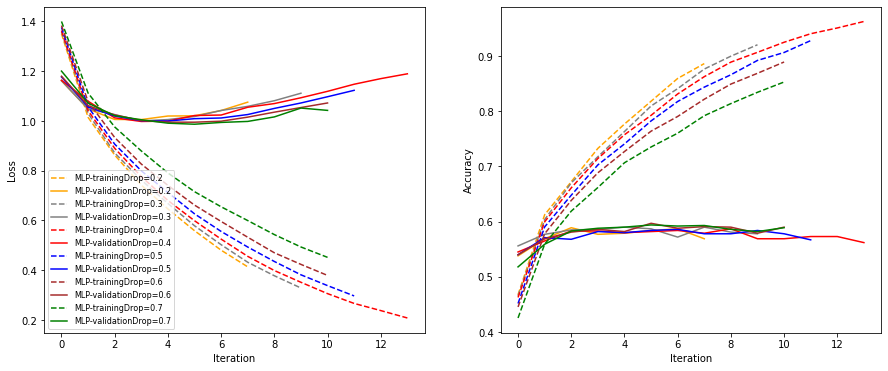

In [25]:
colors = ["orange", "gray", "red", "blue", "brown", "green"]
plt.figure(figsize=(15,6))

for i, (d, history) in enumerate(drop_histories):
    name = "Drop=" + str(d)
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_loss"], label="MLP-validation" + name, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="MLP-validation" + name, color=colors[i])
plt.subplot(1,2,1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.subplot(1,2,2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

Dropout of 0.7 perform the best

But it still overfits a bit

## Testing No. of Layers

In [26]:
num_layers_list = [1, 2, 3, 4]
num_layers_histories = []

for num in num_layers_list:
    model = build_MLP(input_size=len(feats_dict), output_size=num_classes,
                    num_layers=num, hidden_size=200, activation="relu",
                    learning_rate=0.1)
    
    checkpointer = keras.callbacks.ModelCheckpoint(
      filepath=os.path.join("models", "weights_mlp_layers_" + str(num) + ".hdf5"),
      monitor="val_accuracy",
      verbose=0,
      save_best_only=True)
    
    history = model.fit_generator(generator=train_sequence,
                      epochs=EPOCHS, steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE, 
                      callbacks=[checkpointer, earlystopping], 
                      validation_data=valid_sequence, 
                      validation_steps=VALID_SPLIT//BATCH_SIZE, 
                      verbose=0, shuffle=True)
    
    model = keras.models.load_model(os.path.join("models", "weights_mlp_layers_" + str(num) + ".hdf5"))
    num_layers_histories.append((num, history))

    print("No. of Layers:", num)

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                batch_size=100)
    valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


No. of Layers: 1
20/20 [==============================] - 0s 7ms/step - loss: 1.0318 - accuracy: 0.5820
training loss: 0.8056229948997498 training accuracy 0.7401000261306763
valid loss: 1.0317673683166504 valid accuracy 0.5820000171661377
No. of Layers: 2
20/20 [==============================] - 0s 7ms/step - loss: 0.9856 - accuracy: 0.5990
training loss: 0.6488940715789795 training accuracy 0.7840999960899353
valid loss: 0.9855594038963318 valid accuracy 0.5989999771118164
No. of Layers: 3
20/20 [==============================] - 0s 7ms/step - loss: 1.4340 - accuracy: 0.5740
training loss: 0.20611469447612762 training accuracy 0.953000009059906
valid loss: 1.4339638948440552 valid accuracy 0.5740000009536743
No. of Layers: 4
20/20 [==============================] - 0s 7ms/step - loss: 1.0013 - accuracy: 0.5840
training loss: 0.5357439517974854 training accuracy 0.8241999745368958
valid loss: 1.0012702941894531 valid accuracy 0.5839999914169312


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

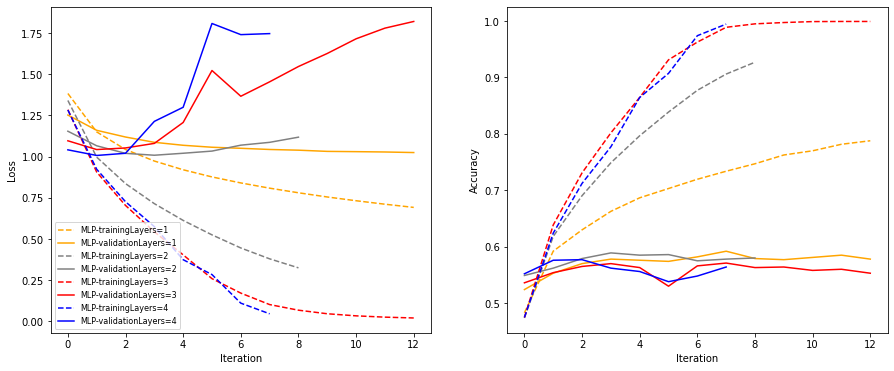

In [27]:
colors = ["orange", "gray", "red", "blue"]
plt.figure(figsize=(15,6))

for i, (num, history) in enumerate(num_layers_histories):
    name = "Layers=" + str(num)
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_loss"], label="MLP-validation" + name, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="MLP-validation" + name, color=colors[i])
plt.subplot(1,2,1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.subplot(1,2,2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

No. of Layers = 1 / 2 perform good with least overfitting

## Testing l2_reg

In [28]:
l2_reg_list = [0.01, 0.05, 0.001, 0.005, 0.0001]
l2_reg_histories = []

for r in l2_reg_list:
    model = build_MLP(input_size=len(feats_dict), output_size=num_classes,
                    num_layers=2, hidden_size=200, activation="relu",
                    l2_reg=r, learning_rate=0.1)
    
    checkpointer = keras.callbacks.ModelCheckpoint(
      filepath=os.path.join("models", "weights_mlp_l2_reg_" + str(num) + ".hdf5"),
      monitor="val_accuracy",
      verbose=0,
      save_best_only=True)
    
    history = model.fit_generator(generator=train_sequence,
                      epochs=EPOCHS, steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE, 
                      callbacks=[checkpointer, earlystopping], 
                      validation_data=valid_sequence, 
                      validation_steps=VALID_SPLIT//BATCH_SIZE, 
                      verbose=0, shuffle=True)
    
    model = keras.models.load_model(os.path.join("models", "weights_mlp_l2_reg_" + str(num) + ".hdf5"))
    l2_reg_histories.append((r, history))

    print("L2 Reg:", r)

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                batch_size=100)
    valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


L2 Reg: 0.01
20/20 [==============================] - 0s 7ms/step - loss: 1.7838 - accuracy: 0.5875
training loss: 1.4536551237106323 training accuracy 0.7989000082015991
valid loss: 1.7838104963302612 valid accuracy 0.5874999761581421
L2 Reg: 0.05
20/20 [==============================] - 0s 7ms/step - loss: 1.7810 - accuracy: 0.5720
training loss: 1.6948171854019165 training accuracy 0.6427000164985657
valid loss: 1.780996322631836 valid accuracy 0.5720000267028809
L2 Reg: 0.001
20/20 [==============================] - 0s 8ms/step - loss: 1.3680 - accuracy: 0.5870
training loss: 1.1299971342086792 training accuracy 0.7315999865531921
valid loss: 1.3680453300476074 valid accuracy 0.5870000123977661
L2 Reg: 0.005
20/20 [==============================] - 0s 7ms/step - loss: 1.6939 - accuracy: 0.5890
training loss: 1.1899259090423584 training accuracy 0.8597000241279602
valid loss: 1.6938974857330322 valid accuracy 0.5889999866485596
L2 Reg: 0.0001
20/20 [==============================] -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

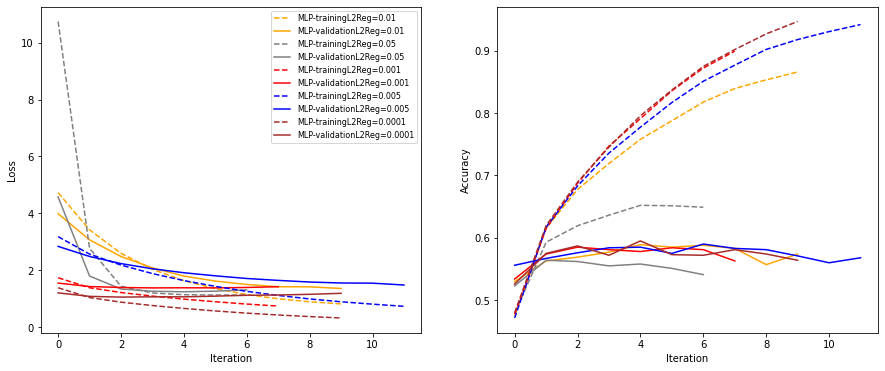

In [29]:
colors = ["orange", "gray", "red", "blue", "brown"]
plt.figure(figsize=(15,6))

for i, (r, history) in enumerate(l2_reg_histories):
    name = "L2Reg=" + str(r)
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_loss"], label="MLP-validation" + name, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="MLP-validation" + name, color=colors[i])
plt.subplot(1,2,1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.subplot(1,2,2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

L2_Reg = 0.0001 performs the best

But it's loss curves depict a bit of overfitting

## Testing LR

In [30]:
lr_list = [0.1, 0.05, 0.01, 0.001]
lr_histories = []

for lr in lr_list:
    model = build_MLP(input_size=len(feats_dict), output_size=num_classes,
                    num_layers=2, hidden_size=200, activation="relu",
                    learning_rate=lr)
    
    checkpointer = keras.callbacks.ModelCheckpoint(
      filepath=os.path.join("models", "weights_mlp_lr_" + str(lr) + ".hdf5"),
      monitor="val_accuracy",
      verbose=0,
      save_best_only=True)
    
    history = model.fit_generator(generator=train_sequence,
                      epochs=EPOCHS, steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE, 
                      callbacks=[checkpointer, earlystopping], 
                      validation_data=valid_sequence, 
                      validation_steps=VALID_SPLIT//BATCH_SIZE, 
                      verbose=0, shuffle=True)
    
    model = keras.models.load_model(os.path.join("models", "weights_mlp_lr_" + str(lr) + ".hdf5"))
    lr_histories.append((lr, history))

    print("LR:", lr)

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                batch_size=100)
    valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


LR: 0.1
20/20 [==============================] - 0s 6ms/step - loss: 0.9925 - accuracy: 0.5920
training loss: 0.6547971963882446 training accuracy 0.7886000275611877
valid loss: 0.9925497770309448 valid accuracy 0.5920000076293945
LR: 0.05
20/20 [==============================] - 0s 7ms/step - loss: 1.0035 - accuracy: 0.5885
training loss: 0.7938076853752136 training accuracy 0.725600004196167
valid loss: 1.0034950971603394 valid accuracy 0.5885000228881836
LR: 0.01
20/20 [==============================] - 0s 7ms/step - loss: 0.9835 - accuracy: 0.5985
training loss: 0.69908207654953 training accuracy 0.7667999863624573
valid loss: 0.9834938645362854 valid accuracy 0.5985000133514404
LR: 0.001
20/20 [==============================] - 0s 6ms/step - loss: 1.1783 - accuracy: 0.5535
training loss: 1.1252188682556152 training accuracy 0.5995000004768372
valid loss: 1.1782926321029663 valid accuracy 0.5534999966621399


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

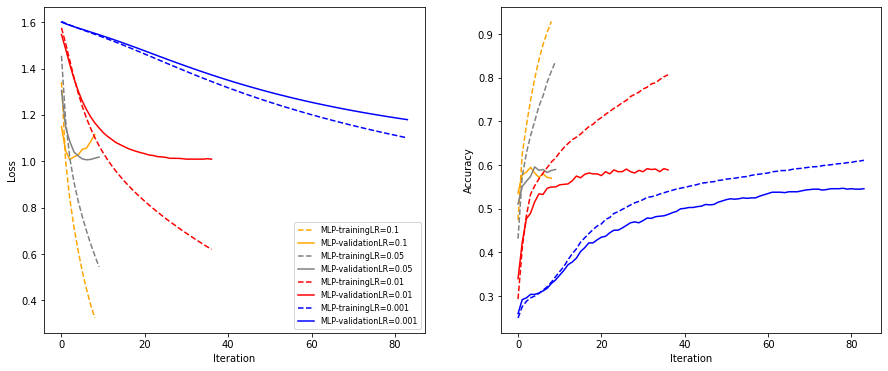

In [31]:
colors = ["orange", "gray", "red", "blue"]
plt.figure(figsize=(15,6))

for i, (lr, history) in enumerate(lr_histories):
    name = "LR=" + str(lr)
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_loss"], label="MLP-validation" + name, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="MLP-validation" + name, color=colors[i])
plt.subplot(1,2,1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.subplot(1,2,2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

LR = 0.01 performs the best

## Testing Hidden Size

In [32]:
hidden_size_list = [50, 200, 400, 800]
hid_histories = []

for h in hidden_size_list:
    model = build_MLP(input_size=len(feats_dict), output_size=num_classes,
                    num_layers=2, hidden_size=h, activation="relu")
    
    checkpointer = keras.callbacks.ModelCheckpoint(
      filepath=os.path.join("models", "weights_mlp_hid_" + str(h) + ".hdf5"),
      monitor="val_accuracy",
      verbose=0,
      save_best_only=True)
    
    history = model.fit_generator(generator=train_sequence,
                      epochs=EPOCHS, steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE, 
                      callbacks=[checkpointer, earlystopping], 
                      validation_data=valid_sequence, 
                      validation_steps=VALID_SPLIT//BATCH_SIZE, 
                      verbose=0, shuffle=True)
    
    model = keras.models.load_model(os.path.join("models", "weights_mlp_hid_" + str(h) + ".hdf5"))
    hid_histories.append((h, history))

    print("Hidden Size:", h)

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                batch_size=100)
    valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Hidden Size: 50
20/20 [==============================] - 0s 6ms/step - loss: 0.9802 - accuracy: 0.5875
training loss: 0.7589052319526672 training accuracy 0.7366999983787537
valid loss: 0.9802355170249939 valid accuracy 0.5874999761581421
Hidden Size: 200
20/20 [==============================] - 0s 7ms/step - loss: 1.0053 - accuracy: 0.5945
training loss: 0.49991586804389954 training accuracy 0.8607000112533569
valid loss: 1.0052542686462402 valid accuracy 0.5945000052452087
Hidden Size: 400
20/20 [==============================] - 0s 7ms/step - loss: 0.9963 - accuracy: 0.6055
training loss: 0.49844813346862793 training accuracy 0.859499990940094
valid loss: 0.9963294863700867 valid accuracy 0.6054999828338623
Hidden Size: 800
20/20 [==============================] - 0s 7ms/step - loss: 0.9891 - accuracy: 0.5995
training loss: 0.5009178519248962 training accuracy 0.8618000149726868
valid loss: 0.9891287088394165 valid accuracy 0.5995000004768372


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

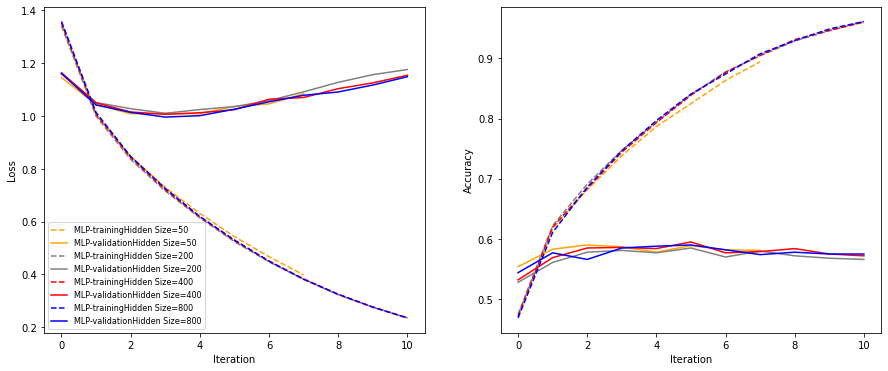

In [33]:
colors = ["orange", "gray", "red", "blue"]
plt.figure(figsize=(15,6))

for i, (h, history) in enumerate(hid_histories):
    name = "Hidden Size=" + str(h)
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_loss"], label="MLP-validation" + name, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="MLP-validation" + name, color=colors[i])
plt.subplot(1,2,1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.subplot(1,2,2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

Hidden Size = 400 performs the best

But all of them are very similar and overfit a bit

## Testing Batch Size

In [22]:
batch_size_list = [128, 256]
batch_histories = []

for b in batch_size_list:
    model = build_MLP(input_size=len(feats_dict), output_size=num_classes,
                    num_layers=2, hidden_size=200, activation="relu")
    
    checkpointer = keras.callbacks.ModelCheckpoint(
      filepath=os.path.join("models", "weights_mlp_batch_" + str(b) + ".hdf5"),
      monitor="val_accuracy",
      verbose=0,
      save_best_only=True)
    
    BATCH_SIZE = b
    
    train_sequence_batch = TextSequence("Train", train_feats_matrix[:9000], train_label_matrix[:9000], True)
    valid_sequence_batch = TextSequence("Valid", train_feats_matrix[9000:], train_label_matrix[9000:], True)
    
    history = model.fit_generator(generator=train_sequence_batch,
                      epochs=EPOCHS, steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE, 
                      callbacks=[checkpointer, earlystopping], 
                      validation_data=valid_sequence_batch, 
                      validation_steps=VALID_SPLIT//BATCH_SIZE, 
                      verbose=0, shuffle=True)
    
    model = keras.models.load_model(os.path.join("models", "weights_mlp_batch_" + str(b) + ".hdf5"))
    batch_histories.append((b, history))

    print("Batch Size:", b)

    train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                                batch_size=100)
    valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                                batch_size=100)
    print("training loss:", train_score[0], "training accuracy", train_score[1])
    print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

    # Resetting BATCH_SIZE to 100
    BATCH_SIZE = 100

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Batch Size: 128
20/20 [==============================] - 0s 7ms/step - loss: 1.0119 - accuracy: 0.5845
training loss: 0.4749395549297333 training accuracy 0.8736000061035156
valid loss: 1.0118842124938965 valid accuracy 0.5845000147819519
Batch Size: 256
20/20 [==============================] - 0s 7ms/step - loss: 0.9874 - accuracy: 0.5915
training loss: 0.6076034307479858 training accuracy 0.8090000152587891
valid loss: 0.9873514175415039 valid accuracy 0.5914999842643738


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier i

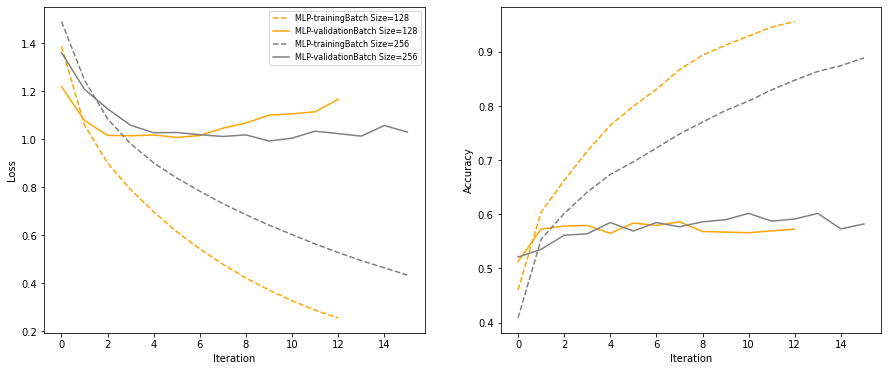

In [23]:
colors = ["orange", "gray", "red", "blue"]
plt.figure(figsize=(15,6))

for i, (b, history) in enumerate(batch_histories):
    name = "Batch Size=" + str(b)
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_loss"], label="MLP-validation" + name, color=colors[i])
    plt.subplot(1,2,2)
    plt.plot(history.history["accuracy"], label="MLP-training" + name, color=colors[i], linestyle="dashed")
    plt.plot(history.history["val_accuracy"], label="MLP-validation" + name, color=colors[i])
plt.subplot(1,2,1)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(fontsize=8)
plt.subplot(1,2,2)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
# plt.legend()
plt.show()

Could only run for batch size 32 and 64

Batch size 64 performs better

Could only run for batch size 64 and 100

Batch size 100 performs better

Could only run for batch size 100 and 128

Batch size 128 performs better

Could only run for batch size 128 and 256

Batch size 256 performs better

## Making the best model

In [55]:
model = build_MLP(input_size=len(feats_dict), output_size=num_classes,
                  num_layers=3, hidden_size=200, activation="relu",
                  l2_reg=0.00005, dropout_rate=0.7, optimizer="SGD", learning_rate=0.01)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights_mlp_best_1.hdf5"),
    monitor="val_accuracy",
    verbose=1,
    save_best_only=True)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1)

earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    verbose=1)

np.random.seed(0)
tf.random.set_seed(0)
best_1_history = model.fit_generator(generator=train_sequence,
                    epochs=EPOCHS, steps_per_epoch=TRAIN_SPLIT//BATCH_SIZE, 
                    callbacks=[checkpointer, earlystopping, reduce_lr], 
                    validation_data=valid_sequence, 
                    validation_steps=VALID_SPLIT//BATCH_SIZE, 
                    verbose=1, shuffle=True)

model = keras.models.load_model(os.path.join("models", "weights_mlp_best_1.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
valid_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("valid loss:", valid_score[0], "valid accuracy", valid_score[1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
90/90 [==============================] - 1s 12ms/step - loss: 1.6596 - accuracy: 0.2283 - val_loss: 1.6100 - val_accuracy: 0.3250

Epoch 00001: val_accuracy improved from -inf to 0.32500, saving model to models/weights_mlp_best_1.hdf5
Epoch 2/100
90/90 [==============================] - 1s 10ms/step - loss: 1.6227 - accuracy: 0.2791 - val_loss: 1.5776 - val_accuracy: 0.3730

Epoch 00002: val_accuracy improved from 0.32500 to 0.37300, saving model to models/weights_mlp_best_1.hdf5
Epoch 3/100
90/90 [==============================] - 1s 10ms/step - loss: 1.5815 - accuracy: 0.3240 - val_loss: 1.5387 - val_accuracy: 0.4270

Epoch 00003: val_accuracy improved from 0.37300 to 0.42700, saving model to models/weights_mlp_best_1.hdf5
Epoch 4/100
90/90 [==============================] - 1s 10ms/step - loss: 1.5537 - accuracy: 0.3470 - val_loss: 1.4908 - val_accuracy: 0.4560

Epoch 00004: val_accuracy improved from 0.42700 to 0.45600, saving model to models/weights_mlp_best_1.hdf5
Epo

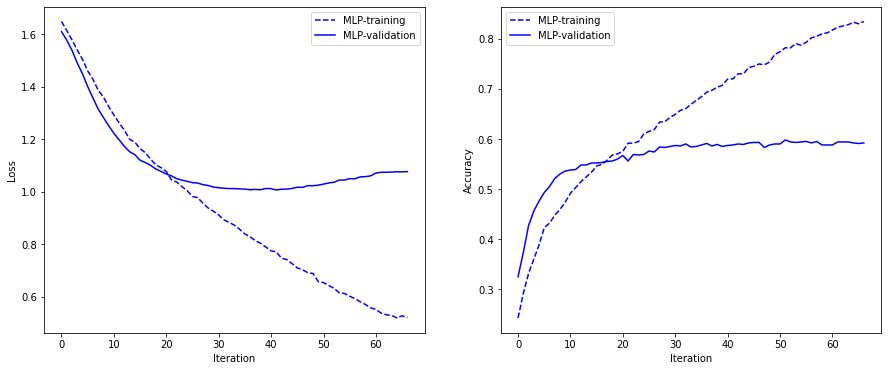

In [56]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(best_1_history.history["loss"], label="MLP-training", color="blue", linestyle="dashed")
plt.plot(best_1_history.history["val_loss"], label="MLP-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(best_1_history.history["accuracy"], label="MLP-training", color="blue", linestyle="dashed")
plt.plot(best_1_history.history["val_accuracy"], label="MLP-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Finalized
* num_layers=3 
* l2_reg=0.00005
* dropout_rate=0.7 
* optimizer="SGD"
* learning_rate=0.01/0.05

Not yet finalized
* hidden_size=200, 
* activation="relu"
* batch_size